In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
#df=pd.read_csv("../../../Col0_HL-LL_PIRK.csv", index_col=0, sep = ",")

In [7]:
m = get_model()

In [8]:
m.remove_reaction("vB6f")

In [9]:
m.add_parameter("b6f_content", 1)
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)

def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

In [10]:
def vB6f(PC, PCred, PQ, PQred, k_b6f ,Keq_cytb6f):    
    k_b6f_reverse = k_b6f / Keq_cytb6f
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 

m.add_reaction(rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [11]:
m.add_parameter("ATPturnover",80)
m.add_parameter("Ratecontrol_ATP", 0.45)


def ATP_gamma(Ratecontrol_ATP, Pi, ATP, ADP ,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000)* Ratecontrol_ATP)

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Ratecontrol_ATP","Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])

def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH) + RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)


In [12]:
def DIRK(s: Simulator,time_relax: float, relax_pfd: float,
         pfd_illumination: float, pre_dark_time:float, post_dark_time):
    t = it.accumulate([pre_dark_time,time_relax,post_dark_time])
    for time, pfd in tqdm(zip(t
                         ,[pfd_illumination,relax_pfd,pfd_illumination])):
        s.update_parameter("pfd", pfd)
        print(pfd)
        print(time)
        s.simulate(time)
        

In [13]:
def PIRK(s: Simulator,time_relax: float, ss_pfd: float, time_pulse: float,
            pfd_dark:float, pfd_pulse: float, time_delay= bool):
    s.update_parameter("pfd", ss_pfd)
    s.simulate(100)
    s.update_parameter("pfd", pfd_dark)
    s.simulate(160)
    pfds = list([pfd_pulse,pfd_dark]*4)
    if time_delay == True:
        t= list(it.accumulate(it.chain.from_iterable((time_pulse, time_relax*i) for i in [1,2,4,0.5])))
    if time_delay == False:
        t = list(it.accumulate(it.chain.from_iterable((time_pulse,time_relax) for i in range(4))))
    
    for i in range(len(t)):
        t[i] = t[i]+160
    #print(t)
    #print(pfds)
    for t,pfd in tqdm(zip(t,pfds)):
        s.update_parameter("pfd", pfd)
        s.simulate(t)
        print(t,pfd)
        

In [14]:
s1 = Simulator(m)
s1.initialise(y0)
s1.clear_results()
DIRK(s1,time_relax=0.1, relax_pfd=10, pfd_illumination=300, 
     pre_dark_time=1200, post_dark_time=0.1)

0it [00:00, ?it/s]

300
1200
10
1200.1
300
1200.1999999999998


In [15]:
c = s1.get_full_results_df()
v = s1.get_fluxes_df()

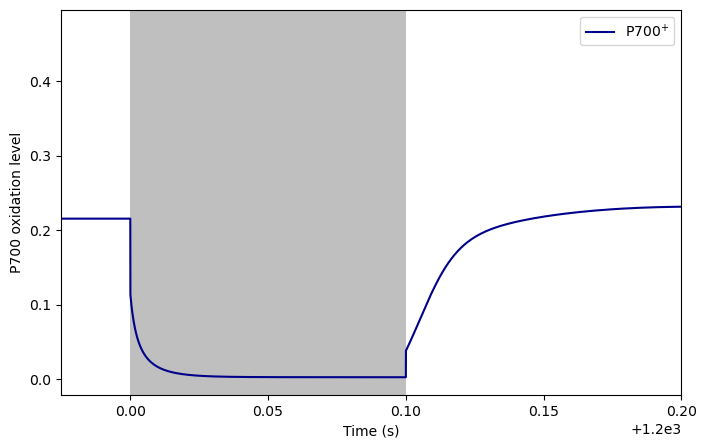

In [16]:
"""
Prior to the measurements, attached leaves of Col-0(black curves) and cfq (red curves) 
were illuminated for at least 20 min with  300 µmol photons·m−2·s−1at and low(50 ppm, thick curves) CO2. 
Kinetics of absorbance changes were measuredusing the IDEASpec device as described in the text. 
As shown in the coloredbands at the top of the graph, the actinic illumination was switched off for 100 ms time intervals 
starting at time zero. Data is plotted as the fraction of P700 oxidized determined by the differences 
in absorbance changes at810–940 nm, normalized to the maximum absorbance changes observedunder 
far red illumination followed by a saturating ﬂash

https://www.researchgate.net/publication/316674887_Chloroplast_ATP_Synthase_Modulation_of_the_Thylakoid_Proton_Motive_Force_Implications_for_Photosystem_I_and_Photosystem_II_Photoprotection
"""
fig,ax=plt.subplots(figsize=(8,5))

ax.plot(c["A2"], label = "P700$^{+}$", color="darkblue")


ax.set(xlim=(1199.975,1200.2),
       xlabel=("Time (s)"),
       ylabel=("P700 oxidation level"))
       
ax.axvspan(1200, 1200.1, color='grey', alpha=0.5, lw=0)
ax.legend()

plt.show()

In [11]:
## possible to calculate pmf with everything thats given to get ot their
#compatable measurement

## or calculate from pmf to a comparable unit we can measure?

In [12]:
##weird stuff: when until 1000 one of the peaks doesnt happen, idk why?
    #ATP synthase looks rough

In [18]:
##to be similar to behavior time_relax=0.05, time_pulse = 0.005, pfd_dark=100, pfd_pulse=450, normal_light=400

s1 = Simulator(m)
s1.initialise(y0)
s1.clear_results()
PIRK(s1,time_relax=0.06, ss_pfd=90, time_pulse=0.003, 
     pfd_dark=10, pfd_pulse=1180, time_delay=True)

0it [00:00, ?it/s]

160.003 1180
160.063 10
160.066 1180
160.186 10
160.189 1180
160.429 10
160.432 1180
160.462 10


In [19]:
c = s1.get_full_results_df()
v = s1.get_fluxes_df()

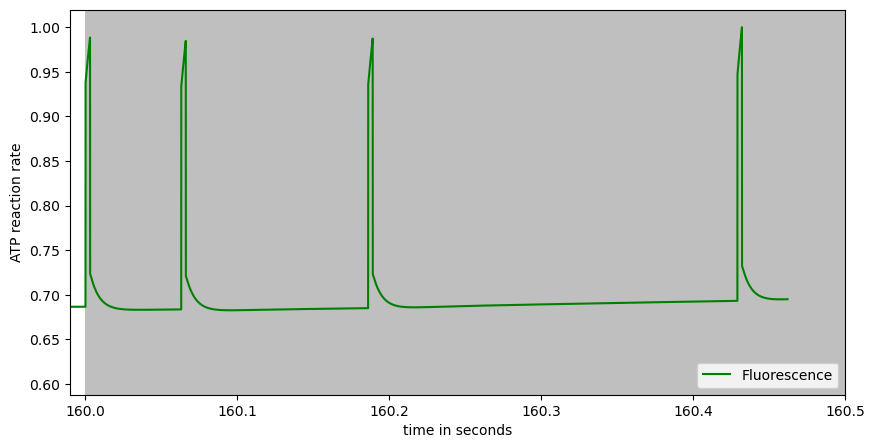

In [22]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["Fluo"]/max(c["Fluo"]), label="Fluorescence", color="green")
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(159.99,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
ax.axvspan(160, 200, color='grey', alpha=0.5, lw=0)
ax.legend()
plt.show()

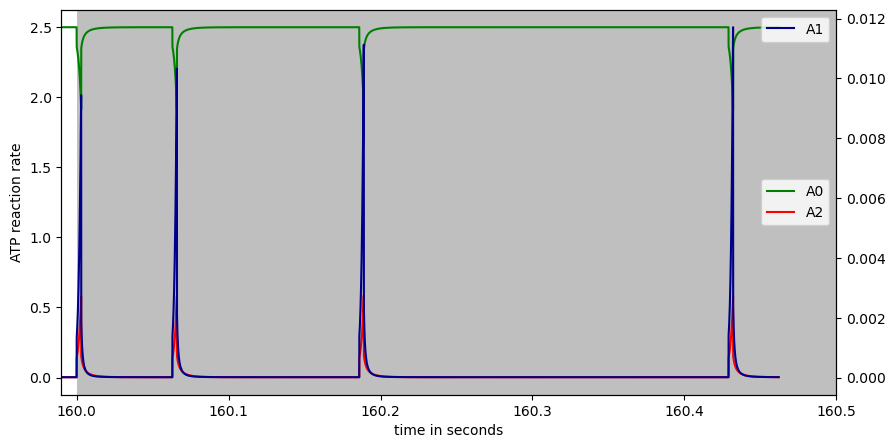

In [23]:
fig,ax=plt.subplots(figsize=(10,5))
ax2= ax.twinx()
ax.plot(c["A0"], label="A0", color="green")
ax2.plot(c["A1"], label="A1", color="darkblue")
ax.plot(c["A2"], label="A2", color ="red")
#ax.plot(v["vATPsynthase"], color="red")
ax.set(ylabel=("Fluorescence"))
ax.set(xlim=(159.99,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
ax.axvspan(160, 200, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

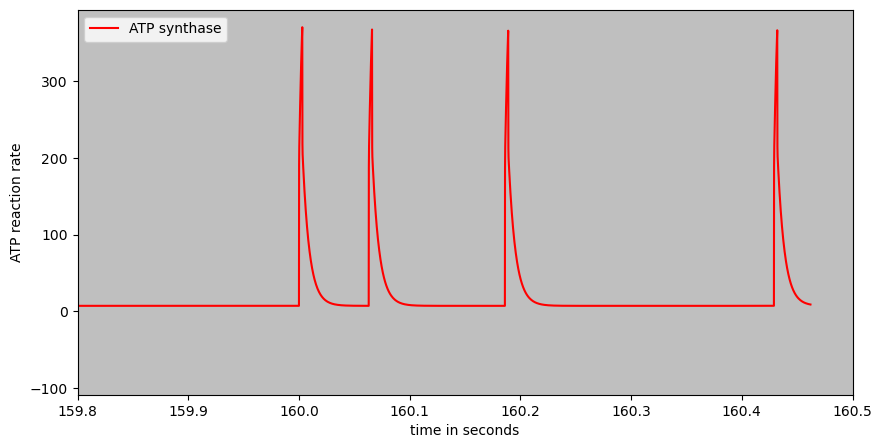

In [24]:
fig,ax=plt.subplots(figsize=(10,5))
#ax.plot(c["Fluo"])
ax.plot(v["vATPsynthase"], color="red", label="ATP synthase")

ax.set(xlim=(159.8,160.5),
       #ylim=(0.16,0.5),
       xlabel=("time in seconds"),
       ylabel=("ATP reaction rate"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
ax.axvspan(100, 660, color='grey', alpha=0.5, lw=0)
ax.legend()
plt.show()

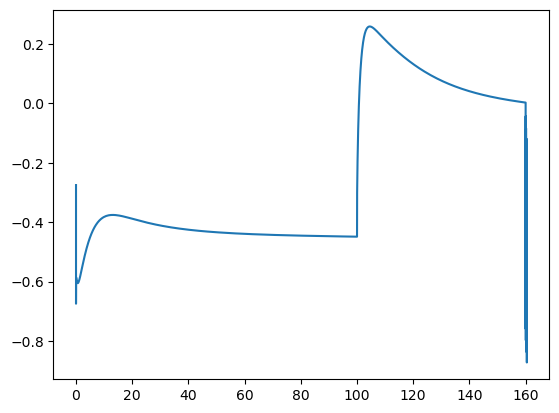

In [25]:
plt.plot(-np.log(s1.get_full_results_df()["Keq_ATPsynthase"])/m.get_parameter("RT"))


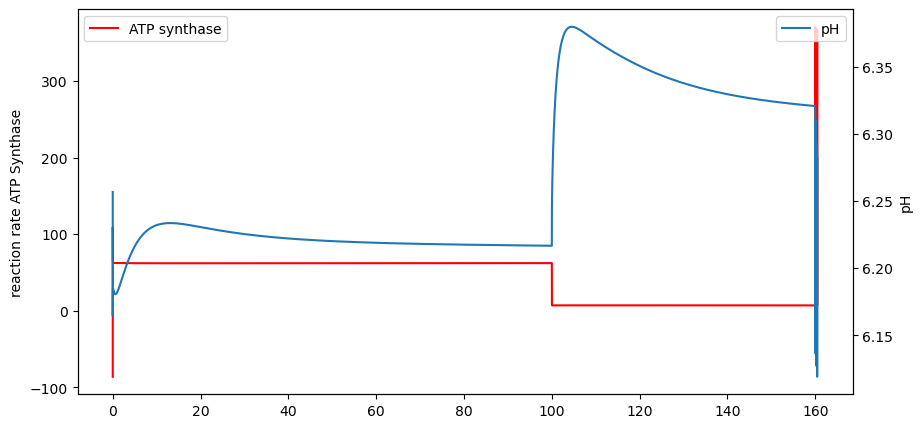

In [35]:
fig,ax=plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax2.plot(c["pH"], label="pH")
ax.plot(v["vATPsynthase"], color="red",label="ATP synthase")
ax.set(ylabel=("reaction rate ATP Synthase"))
#ax.set(xlim=(159,160.5),
       #ylim=(0.16,0.5),
       #xlabel=("time in seconds"),
       #ylabel=("ATP reaction rate"))
ax2.set(ylabel=("pH"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
#ax.axvspan(150,240, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

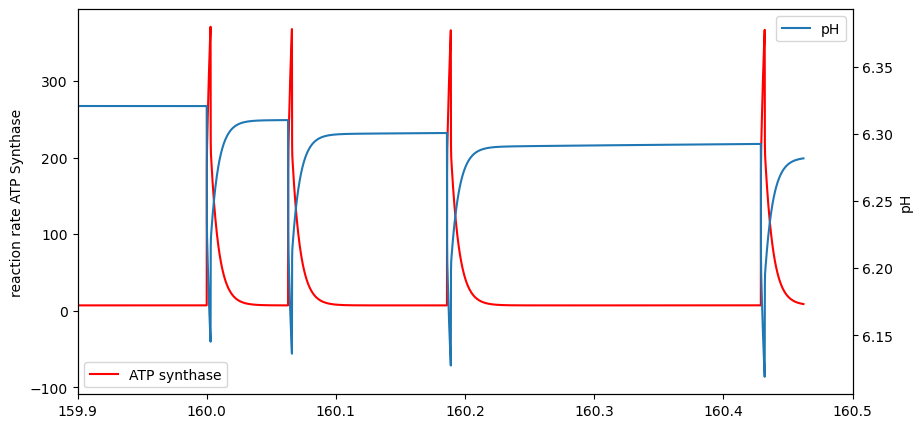

In [37]:
fig,ax=plt.subplots(figsize=(10,5))
ax2 = ax.twinx()
ax2.plot(c["pH"], label="pH")
ax.plot(v["vATPsynthase"], color="red",label="ATP synthase")
ax.set(ylabel=("reaction rate ATP Synthase"))
ax.set(xlim=(159.9,160.5))
ax2.set(ylabel=("pH"))
#ax.set_xticklabels(["1200","1300","1400","1500","1600","1700","1800"])
#ax.axvspan(150,240, color='grey', alpha=0.5, lw=0)
ax.legend()
ax2.legend()
plt.show()

In [38]:
c = s1.get_full_results_df()
f = s1.get_fluxes_df()
B0 = s1.get_variable("B0")
B2 = s1.get_variable("B2")
ADP = 1-c["ATP_norm"]

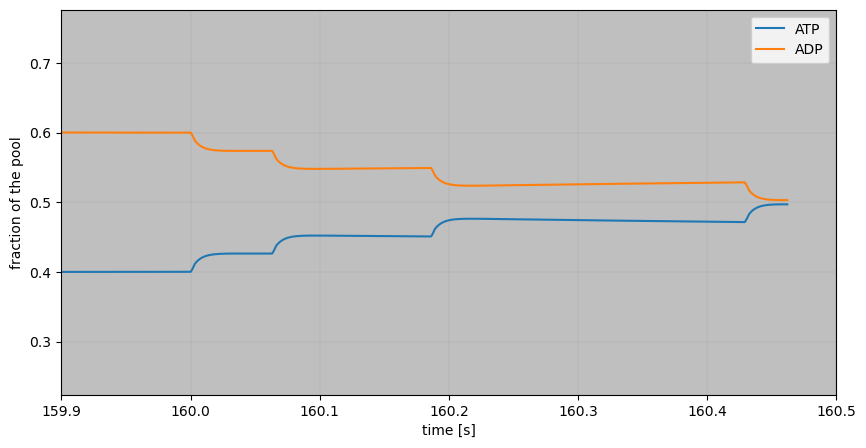

In [40]:
###ATP and ADP
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(c["ATP_norm"], label= "ATP")
ax.set(xlim=(159.9,160.5))

ax.plot(ADP, label = "ADP")
plt.ylabel("fraction of the pool")
plt.xlabel("time [s]")
plt.axvspan(150, 240, color='grey', alpha=0.5, lw=0)
plt.grid(color='grey', linestyle='-', linewidth=0.1)
plt.legend(loc="best")
plt.show()

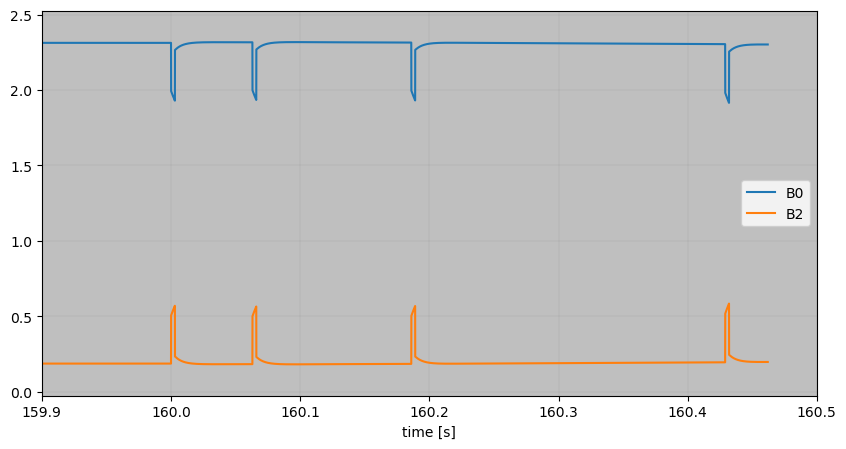

In [43]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(f.index, B0, label="B0")
ax.plot(f.index, B2, label="B2")
ax.set(xlim=(159.9,160.5))
plt.xlabel("time [s]")
plt.axvspan(100, 650, color='grey', alpha=0.5, lw=0)
plt.grid(color='grey', linestyle='-', linewidth=0.1)
plt.legend(loc="best")